1. [Setup data set](#qH6NSvLcvWq0dIOGUFm7hjIWOO9EcDo4yg)
2. [Define Mine model](#LWu8a55iXd1rXiOxqHLRRPEri06W2uHUSaopejkOyLc)
3. First architecture
    1. [Compute MI of fine-grained model with Net 1](#ITDw/rAcOpXEcj2/jr66qiHnAVLmZUerYxogQhfGZKU)
        1. [Compute MI of fine-grained model with Net 1 (learning rate experiment)](#rsXTn4Xt28E5GogIizo92r/Pd6a2FFGwwk7KSKGENeY)
    2. [Compute MI of frozen convolution with Net 1](#XwBXAc9EQHz4UXGAypEpu8Nx1VSK7MgK6aV54)
4. [Alternative architecture](#bmPi9gykQdCvsmB9Ey9o3N0Z2tpRuAEEgPXrIqeLp5M8)
    1. [Compute MI of fine-grained 3x3 model with Net 2](#XMXqmJFyTasMbsY1APB9UEA)
        1. [Compute MI of fine-grained 3x3 model with Net 2 (learning rate scheduler experiment)](#ks6iDaSVrGnNdtAaveXITBiwGVqpS4aom7JFAik9UsY)
    2. [Compute MI of frozen 3x3 convolution with Net 2](#StnSWBsZkvH19fVkpidI)
        1. [Compute MI of frozen 3x3 convolution with Net 2 (learning rate scheduler experiment)](#75w0xiOCI1V0afZ12xKy4NqY)
        2. [Compute MI of frozen 3x3 convolution with Net 2 (learning rate)](#yjaFT5zBKGsxifupr2J1qLx8w)
    3. [Mine on the fine-grained data (on the 2x2 model)](#zu750PMa3YAxhw2z49AvlNJP1DE)
    4. [Mine on the coarse-grained frozen convolution (on the 2x2 model)](#FxFiXG4HyPIyOgPFs3aNTLDoI)
    5. [Jointly optimize the coarse-grained convolution (on the 2x2 model) and MI of coarse-grained convolution](#gS7O2ggXcb34OJzzvfm2crOhmEGCROW)
4. [Scaling of MI](#jQUDGTEY1JJS2qrno8VVzw7rC1515jg)
    1. [Scaling of MI as concentric squares](#LptD8gfpTFYcDRp8bfbY05ZU)
    2. [Scaling of MI as lines](#FC1gLaEA6K8I1foE2nBC56vBPn9n3pC4tuSypqA3BN8)
5. [Compare MINE vs. Joint-vs-Marginal Estimators](#uUErzTXITRwiuLX3vbfqwnke2vR86I8SGE7kaab8V14)
    1. [MINE on 2 1D Gaussians](#urFfwvFLj2Tz0PwJR8g)
    2. [p/(1-p) on 2 1D Gaussians](#uhpeGwwardgoo/fW6QB9f7)
    3. [MINE on 2 10D Gaussians](#U5pun0GG3L7I5Kawd5kg5S0vDRqOiUu92bwFgd1rjyw)
    4. [p/(1-p) on 2 10D Gaussians](#lOMJw8rnW3QXotwiPSoTrhN2AoP2O0pMG1QA5M)
5. [Analytic MI frozen convolution](#IMXNuzYpbqF3yE71tcGPkyCUgonu44gg0wtJKI)
    1. [Analytic fine-grained MI calculation](#W6fWYl5TZGWfK9Zt8dXCH65nSc5Uk)
    2. [Analytic MI frozen convolution](#i4EUlSNUCLAqQFRTDCFVrpJ)









# Setup dataset
<a id='qH6NSvLcvWq0dIOGUFm7hjIWOO9EcDo4yg'></a>

In [ ]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append("/gpfs/loomis/project/turk-browne/an633/renormalization/")

from tqdm import tqdm
# from mine.models.mine import Mine
dat = np.load("ising27x27from2187x2187.npy")
class Net(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 100):
        super(Net, self).__init__()
        self.x_fc1 = nn.Linear(x_dim, H)
        self.x_fc3 = nn.Linear(H, H)
        
        self.y_fc1 = nn.Linear(y_dim, H)
        self.y_fc3 = nn.Linear(H, H)
        
        self.fc3 = nn.Linear(H, H // 4)
        self.fc4 = nn.Linear(H // 4, 1)
        
        
    def forward(self, x, y):
        inter_x = F.relu(self.x_fc1(x))
        inter_x = F.relu(self.x_fc3(inter_x))
        
        inter_y = F.relu(self.y_fc1(y))
        inter_y = F.relu(self.y_fc3(inter_y))
        
        
        h2 = F.relu(self.fc3(inter_x + inter_y))
        h2 = (self.fc4(h2))
        return h2    


In [ ]:
Xlist = []
Ylist = []
for _ in range(10000):
    num = np.random.randint(dat.shape[0])
    i = np.random.randint(dat.shape[1] - 3)
    j = np.random.randint(dat.shape[1] - 6)
#     if _ < 20:
#         print(dat[num, i:(i+3), j:(j+6)])
    Xlist.append(dat[num, i:(i+3), j:(j+3)])
    Ylist.append(dat[num, i:(i+3), (j+3):(j+6)])

X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)

In [ ]:

class DatasetVar(Dataset):
    def __init__(self, varX, varY):
        self.varX = varX
        self.varY = varY
        
        assert len(varX) == len(varY), "X and Y must have equal length"
    def __len__(self):
        return len(self.varX)
    def __getitem__(self, idx):
        return self.varX[idx], self.varY[idx]
    
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)



# Define Mine model
<a id='LWu8a55iXd1rXiOxqHLRRPEri06W2uHUSaopejkOyLc'></a>

In [1]:
from mine.models.layers import ConcatLayer, CustomSequential
from mine.models.mine import EMALoss, ema, ema_loss

class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)
        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])
            #print("t_marg", t_marg.shape, t_marg)
            #print("second_term", second_term)
        #print(-t, second_term)
        return -t + second_term

    def mi(self, x, z, z_marg=None):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        if isinstance(z, np.ndarray):
            z = torch.from_numpy(z).float()

        with torch.no_grad():
            mi = -self.forward(x, z, z_marg)
        return mi

    def optimize(self, X, Y, iters, batch_size, lr=1e-4, opt=None, train_loader = None, schedule = None):
        
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        if schedule is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                        step_size=schedule['step_size'], 
                                                        gamma=schedule['gamma'])


        for iter in range(1, iters + 1):
            
            mu_mi = 0
            # for x, y in mine.utils.batch(X, Y, batch_size):
            for batch, (x, y) in enumerate(train_loader):
                opt.zero_grad()
                loss = self.forward(x.float().cuda(), y.float().cuda())
                loss.backward()
                opt.step()

                mu_mi -= loss.item()
            #iter_print = iter //  3
            iter_print = 3
            if iter % (iter_print) == 0:
                # pass
                print(f"It {iter} - MI: {mu_mi / batch_size} ")
            
            iter_mi = 30
            if iter % (iter_mi) == 0:
                current_mi = self.mi(torch.Tensor(X).cuda(), torch.Tensor(Y).cuda())
                print(f"It {iter} - Current MI: {current_mi} ")
        final_mi = self.mi(X, Y)
        print(f"Final MI: {final_mi}")
        return final_mi

import torch.distributed as dist

mine = Mine(
    T = Net(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
).cuda()
# dist_backend = 'nccl'
# dist_url = 'tcp://224.66.41.62:23456'
# world_size = -1

# ngpus_per_node = torch.cuda.device_count()

# dist.init_process_group(backend=dist_backend, init_method=dist_url,  world_size=world_size, rank= rank)
# mine = torch.nn.parallel.DistributedDataParallel(mine)


Device: cuda


NameError: name 'nn' is not defined

### Compute MI of fine-grained model with Net 1
<a id='ITDw/rAcOpXEcj2/jr66qiHnAVLmZUerYxogQhfGZKU'></a>

In [ ]:
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


In [ ]:
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


#### Compute MI of fine-grained model with Net 1 (learning rate experiment)
<a id='rsXTn4Xt28E5GogIizo92r/Pd6a2FFGwwk7KSKGENeY'></a>

In [ ]:
mine = Mine(
    T = Net(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
)
X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.0001)


### Compute MI of frozen convolution with Net 1
<a id='XwBXAc9EQHz4UXGAypEpu8Nx1VSK7MgK6aV54'></a>

In [ ]:
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

In [ ]:
mine = Mine(
    T = Net(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)

train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


In [ ]:
mine = Mine(
    T = Net(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


## Alternative architecture
<a id='bmPi9gykQdCvsmB9Ey9o3N0Z2tpRuAEEgPXrIqeLp5M8'></a>

In [ ]:
class AltNet(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 100):
        super(AltNet, self).__init__()
        self.x_fc1 = nn.Linear(x_dim + y_dim, H)
        self.x_fc2 = nn.Linear(H, H)
        self.x_fc3 = nn.Linear(H, H)
        self.x_fc4 = nn.Linear(H, 1)
        
        
    def forward(self, x, y):
        xy = torch.cat([x, y], 1) # dim [batch, 2]
        inter_xy = F.relu(self.x_fc1(xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc2(inter_xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc3(inter_xy)) # dim [batch, 100]
        
        h2 = (self.x_fc4(inter_xy))
        return h2    

### Compute MI of fine-grained 3x3 model with Net 2
<a id='XMXqmJFyTasMbsY1APB9UEA'></a>

In [ ]:
mine = Mine(
    T = AltNet(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
)
X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001)


#### Compute MI of fine-grained 3x3 model with Net 2 (learning rate scheduler experiment)
<a id='ks6iDaSVrGnNdtAaveXITBiwGVqpS4aom7JFAik9UsY'></a>

In [ ]:
mine = Mine(
    T = AltNet(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
)
X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


### Compute MI of frozen convolution with Net 2
<a id='StnSWBsZkvH19fVkpidI'></a>

In [ ]:
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)



#### Compute MI of frozen convolution with Net 2 (learning rate scheduler experiment)
<a id='75w0xiOCI1V0afZ12xKy4NqY'></a>

In [ ]:
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


#### Compute MI of frozen convolution with Net 2 (learning rate)
<a id='yjaFT5zBKGsxifupr2J1qLx8w'></a>

In [ ]:
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.01, 
                   schedule = {'step_size': 30, 'gamma': 0.3})


In [ ]:
Xlist

## Mine on the fine-grained data (on the 2x2 model)
<a id='zu750PMa3YAxhw2z49AvlNJP1DE'></a>

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from glob import glob
from tqdm import tqdm
from mine.models.layers import ConcatLayer, CustomSequential
from mine.models.mine import EMALoss, ema, ema_loss
import dill
import gc

    
# import ray

# ray.init()
class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)
        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])
            #print("t_marg", t_marg.shape, t_marg)
            #print("second_term", second_term)
        #print(-t, second_term)
        return -t + second_term

    def mi(self, x, z, z_marg=None):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        if isinstance(z, np.ndarray):
            z = torch.from_numpy(z).float()

        with torch.no_grad():
            mi = -self.forward(x, z, z_marg)
        return mi

    def optimize(self, X, Y, iters, batch_size, lr=1e-4, opt=None, 
                 train_loader = None, schedule = None, iter_mi = 30):
        best_mi = -1
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        if schedule is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                        step_size=schedule['step_size'], 
                                                        gamma=schedule['gamma'])


        for iter in range(1, iters + 1):
            
            mu_mi = 0
            # for x, y in mine.utils.batch(X, Y, batch_size):
            for batch, (x, y) in enumerate(train_loader):
                opt.zero_grad()
                loss = self.forward(x.float().cuda(), y.float().cuda())
                loss.backward(retain_graph=True)
                opt.step()

                mu_mi -= loss.item()
            #iter_print = iter //  3
            iter_print = 3
            if iter % (iter_print) == 0:
                # pass
                print(f"It {iter} - MI: {mu_mi / batch_size} ")
            
            if iter % (iter_mi) == 0:
                current_mi = self.mi(torch.Tensor(X).cuda(), torch.Tensor(Y).cuda())
                print(f"It {iter} - Current MI: {current_mi} ")
                if best_mi < current_mi:
                    best_mi = current_mi
        final_mi = self.mi(torch.Tensor(X).cuda(), torch.Tensor(Y).cuda())
        print(f"Final MI: {final_mi}")
        if best_mi < final_mi:
            best_mi = final_mi
        return final_mi, best_mi



class AltNet(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 100):
        super(AltNet, self).__init__()
        self.x_fc1 = nn.Linear(x_dim + y_dim, H)
        self.x_fc2 = nn.Linear(H, H)
        self.x_fc3 = nn.Linear(H, H)
        self.x_fc4 = nn.Linear(H, 1)
        
        
    def forward(self, x, y):
        xy = torch.cat([x, y], 1) # dim [batch, 2]
        inter_xy = F.relu(self.x_fc1(xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc2(inter_xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc3(inter_xy)) # dim [batch, 100]
        
        h2 = (self.x_fc4(inter_xy))
        return h2    

class DatasetVar(Dataset):
    def __init__(self, varX, varY):
        self.varX = varX
        self.varY = varY
        
        assert len(varX) == len(varY), "X and Y must have equal length"
    def __len__(self):
        return len(self.varX)
    def __getitem__(self, idx):
        return self.varX[idx], self.varY[idx]
    
# load 2x4 rectangles
# dat = np.load("ising27x27from2187x2187.npy")
# Xlist = []
# Ylist = []
# for _ in range(100000):
#     num = np.random.randint(dat.shape[0])
#     i = np.random.randint(dat.shape[1] - 2)
#     j = np.random.randint(dat.shape[1] - 4)
#     Xlist.append(dat[num, i:(i+2), j:(j+2)])
#     Ylist.append(dat[num, i:(i+2), (j+2):(j+4)])



Device: cuda


In [ ]:
mine = Mine(
    T = AltNet(x_dim =  4, y_dim = 4),
    loss = 'mine' #mine_biased, fdiv
).cuda()

X = np.array(Xlist).astype(float).reshape(-1, 4)
Y = np.array(Ylist).astype(float).reshape(-1, 4)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=512)
mi = mine.optimize(X, Y, iters = 10, batch_size = 512,  iter_mi = 1,
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


In [5]:
np.save("ising200x200from2187x2187.npy",v)

## Mine on the coarse-grained frozen convolution (on the 2x2 model)
<a id='FxFiXG4HyPIyOgPFs3aNTLDoI'></a>

In [ ]:
X = 1/4 * (np.array(Xlist).astype(float).sum(axis = (1, 2))  ).reshape(-1, 1)
Y = 1/4 * (np.array(Ylist).astype(float).sum(axis = (1, 2))  ).reshape(-1, 1)
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
print(X.shape)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


## Jointly optimize the coarse-grained convolution (on the 2x2 model) and MI of coarse-grained convolution
<a id='gS7O2ggXcb34OJzzvfm2crOhmEGCROW'></a>

In [5]:

class CoarseGrain(nn.Module):
    """
    Neural network to coarse-grain a 2x2 model
    Assume input has been flattened
    """
    def __init__(self, x_dim):
        super(CoarseGrain, self).__init__()
        self.weights = nn.Linear(x_dim, 1, bias = False)

        
    def forward(self, fine_grained):
        coarse_grained = self.weights(fine_grained)
        return coarse_grained
        
        

class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)
        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])
            #print("t_marg", t_marg.shape, t_marg)
            #print("second_term", second_term)
        #print(-t, second_term)
        return -t + second_term

    def mi(self, x, z, z_marg=None):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        if isinstance(z, np.ndarray):
            z = torch.from_numpy(z).float()

        with torch.no_grad():
            mi = -self.forward(x, z, z_marg)
        return mi

    def optimize(self, X, Y, iters, batch_size, lr=1e-4, opt=None, 
                 train_loader = None, schedule = None, iter_mi = 30):
        best_mi = -1
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        if schedule is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                        step_size=schedule['step_size'], 
                                                        gamma=schedule['gamma'])


        for iter in range(1, iters + 1):
            
            mu_mi = 0
            # for x, y in mine.utils.batch(X, Y, batch_size):
            for batch, (x, y) in enumerate(train_loader):
                opt.zero_grad()
                loss = self.forward(x.float(), y.float())
                loss.backward(retain_graph=True)
                opt.step()

                mu_mi -= loss.item()
            #iter_print = iter //  3
            iter_print = 3
            if iter % (iter_print) == 0:
                # pass
                print(f"It {iter} - MI: {mu_mi / batch_size} ")
            
            if iter % (iter_mi) == 0:
                current_mi = self.mi(X, Y)
                print(f"It {iter} - Current MI: {current_mi} ")
                if best_mi < current_mi:
                    best_mi = current_mi
        final_mi = self.mi(X, Y)
        print(f"Final MI: {final_mi}")
        if best_mi < final_mi:
            best_mi = final_mi
        return final_mi, best_mi





def maximize_coarse_grain_MI(train_coarse_grain_iters, 
                             train_mine_iters, dat=None, lr=0.01, 
                             coarse_grainer_opt = None, coarse_grain_schedule = None):
    coarse_grainer = CoarseGrain(9).cuda()
    if coarse_grainer_opt is None:
        coarse_grainer_opt = torch.optim.Adam(coarse_grainer.parameters(), lr=lr)
    if coarse_grain_schedule is not None:
        coarse_grain_scheduler = torch.optim.lr_scheduler.StepLR(coarse_grainer_opt, 
                                                    step_size=schedule['step_size'], 
                                                    gamma=schedule['gamma'])

    mine = Mine(
        T = AltNet(x_dim =  1, y_dim = 1),
        loss = 'mine' #mine_biased, fdiv
    ).cuda()
    mine_opt = None

    
    for _ in range(train_coarse_grain_iters):
        
        X = []
        Y = []
        for _ in range(3000):
            num = np.random.randint(dat.shape[0])
            i = np.random.randint(dat.shape[1] - 3)
            j = np.random.randint(dat.shape[1] - 6)
            X.append(dat[num, i:(i+3), j:(j+3)])
            Y.append(dat[num, i:(i+3), (j+3):(j+6)])
        X = torch.Tensor(np.array(X).astype(float).reshape(-1, 9)).cuda() 
        Y = torch.Tensor(np.array(Y).astype(float).reshape(-1, 9)).cuda()

        coarse_grained_X = coarse_grainer(X)
        coarse_grained_Y = coarse_grainer(Y)

        train_loader = DataLoader(DatasetVar(coarse_grained_X, coarse_grained_Y), 
                                  batch_size=256, shuffle=True)
        # Update MINE estimator
        final_mi, best_mi = mine.optimize(coarse_grained_X, coarse_grained_Y, 
                                     iters = train_mine_iters, batch_size = 512, 
                       train_loader = train_loader, lr = 0.003, opt = None,
                       schedule = {'step_size': 30, 'gamma': 0.5})
        
        # Update coarse graining
        train_loader = DataLoader(DatasetVar(X, Y), batch_size=512, shuffle=True)
        batching = 10 if _ < 5 else 1000000
        for batch, (x, y) in enumerate(train_loader):
            coarse_grainer_opt.zero_grad()
            loss = mine(coarse_grainer(x), coarse_grainer(y))
            loss.backward()
            coarse_grainer_opt.step()
            if batch > batching:
                break

        iter_print = 1
        if _ % (iter_print) == 0:
            # pass
            print(f"It {_} - MI: {mine.mi(coarse_grained_X, coarse_grained_Y)} ")
            for param in coarse_grainer.parameters():
                print (param)
    return coarse_grainer, mine
            
dat = np.load("ising200x200from2187x2187.npy")
mine = maximize_coarse_grain_MI(100, 5, dat=dat)   
# print(coarse_grainer(X).shape)
# for param in coarse_grainer.parameters():
#     print (param)
# print(X[:10])



It 3 - MI: 0.00031757809074406396 
Final MI: 0.026819273829460144
It <built-in function iter> - MI: 0.02068689651787281 
Parameter containing:
tensor([[ 0.1276, -0.2695, -0.1174,  0.2157, -0.2941,  0.1006, -0.2515,  0.1856,
         -0.2813]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.004320644278777763 
Final MI: 0.19557635486125946
It <built-in function iter> - MI: 0.18373696506023407 
Parameter containing:
tensor([[ 0.0800, -0.2868, -0.1465,  0.1654, -0.3111,  0.0593, -0.2942,  0.1436,
         -0.3114]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.00606921999133192 
Final MI: 0.27074068784713745
It <built-in function iter> - MI: 0.2588759958744049 
Parameter containing:
tensor([[ 0.0332, -0.2776, -0.1733,  0.1179, -0.2988,  0.0259, -0.3318,  0.1033,
         -0.3294]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.006955186923732981 
Final MI: 0.3175695240497589
It <built-in function iter> - MI: 0.30918052792549133 
Parameter containing:
tensor([[-0.0157, -0.2595,

It 3 - MI: 0.009479686501435935 
Final MI: 0.39710062742233276
It <built-in function iter> - MI: 0.39361879229545593 
Parameter containing:
tensor([[-0.2974, -0.0945, -0.2783, -0.2185, -0.0242, -0.1621, -0.3014, -0.0706,
         -0.3212]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.009796769707463682 
Final MI: 0.3761315643787384
It <built-in function iter> - MI: 0.4088812470436096 
Parameter containing:
tensor([[-0.2988, -0.0976, -0.2910, -0.2135, -0.0270, -0.1726, -0.2976, -0.0586,
         -0.3223]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.009369069884996861 
Final MI: 0.3937004804611206
It <built-in function iter> - MI: 0.4013359546661377 
Parameter containing:
tensor([[-0.2968, -0.0924, -0.2992, -0.2063, -0.0296, -0.1787, -0.2996, -0.0554,
         -0.3232]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.010152923641726375 
Final MI: 0.42923757433891296
It <built-in function iter> - MI: 0.4305252432823181 
Parameter containing:
tensor([[-0.2940, -0.0877, -0.3

It 3 - MI: 0.010105791734531522 
Final MI: 0.41713792085647583
It <built-in function iter> - MI: 0.3868252635002136 
Parameter containing:
tensor([[-0.3235, -0.1071, -0.3501, -0.2198, -0.0050, -0.2016, -0.3342, -0.1064,
         -0.3310]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.009728437376907095 
Final MI: 0.43465152382850647
It <built-in function iter> - MI: 0.4808613359928131 
Parameter containing:
tensor([[-0.3216, -0.1039, -0.3476, -0.2164, -0.0021, -0.2102, -0.3319, -0.0986,
         -0.3384]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.00998872914351523 
Final MI: 0.4413411617279053
It <built-in function iter> - MI: 0.44224095344543457 
Parameter containing:
tensor([[-0.3170, -0.1073, -0.3449, -0.2198, -0.0090, -0.2205, -0.3371, -0.0879,
         -0.3382]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.010086501075420529 
Final MI: 0.4140858054161072
It <built-in function iter> - MI: 0.4097829759120941 
Parameter containing:
tensor([[-0.3231, -0.1063, -0.33

It 3 - MI: 0.009732818987686187 
Final MI: 0.41768357157707214
It <built-in function iter> - MI: 0.4305954575538635 
Parameter containing:
tensor([[-0.4015, -0.0736, -0.4023, -0.2715, -0.0042, -0.2593, -0.4205, -0.1266,
         -0.3990]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.00978404504712671 
Final MI: 0.4404984414577484
It <built-in function iter> - MI: 0.4027615487575531 
Parameter containing:
tensor([[-0.4010, -0.0833, -0.4074, -0.2686,  0.0021, -0.2610, -0.4229, -0.1271,
         -0.4062]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.010064452129881829 
Final MI: 0.3955393433570862
It <built-in function iter> - MI: 0.4491206109523773 
Parameter containing:
tensor([[-0.3983, -0.0911, -0.4114, -0.2617,  0.0037, -0.2513, -0.4183, -0.1260,
         -0.4009]], device='cuda:0', requires_grad=True)
It 3 - MI: 0.010128391499165446 
Final MI: 0.45902955532073975
It <built-in function iter> - MI: 0.40710464119911194 
Parameter containing:
tensor([[-0.3969, -0.0915, -0.41

### Analyze whether unfrozen coarse-graining has collapsed latent space

In [9]:
coarse_grainer, miner = mine

In [11]:
miner

Mine(
  (T): AltNet(
    (x_fc1): Linear(in_features=2, out_features=100, bias=True)
    (x_fc2): Linear(in_features=100, out_features=100, bias=True)
    (x_fc3): Linear(in_features=100, out_features=100, bias=True)
    (x_fc4): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [12]:
# for _ in range(3000):
#     num = np.random.randint(dat.shape[0])
#     i = np.random.randint(dat.shape[1] - 3)
#     j = np.random.randint(dat.shape[1] - 6)
#     X.append(dat[num, i:(i+3), j:(j+3)])
#     Y.append(dat[num, i:(i+3), (j+3):(j+6)])
# X = torch.Tensor(np.array(X).astype(float).reshape(-1, 9)).cuda() 
# Y = torch.Tensor(np.array(Y).astype(float).reshape(-1, 9)).cuda()

import itertools
lst = list(itertools.product([0, 1], repeat=9))
lst = np.array(lst)
X, Y = zip(*list(itertools.product(lst, repeat=2)))
X = torch.Tensor(np.array(X).astype(float).reshape(-1, 9)).cuda() 
Y = torch.Tensor(np.array(Y).astype(float).reshape(-1, 9)).cuda()
coarse_grained_X = coarse_grainer(X)
coarse_grained_Y = coarse_grainer(Y)
mi = miner.mi(coarse_grained_X, coarse_grained_Y)

In [15]:
coarse_grained_X

tensor([[ 0.0000],
        [ 0.0000],
        [ 0.0000],
        ...,
        [-2.3080],
        [-2.3080],
        [-2.3080]], device='cuda:0', grad_fn=<MmBackward>)

In [16]:
coarse_grained_Y

tensor([[ 0.0000],
        [-0.3671],
        [-0.0936],
        ...,
        [-2.2144],
        [-1.9409],
        [-2.3080]], device='cuda:0', grad_fn=<MmBackward>)

In [25]:
torch.cat([coarse_grained_X[0].reshape(-1, 1),  coarse_grained_Y[1:100]])

tensor([[ 0.0000],
        [-0.3671],
        [-0.0936],
        [-0.4607],
        [-0.4070],
        [-0.7741],
        [-0.5006],
        [-0.8678],
        [-0.2472],
        [-0.6144],
        [-0.3409],
        [-0.7080],
        [-0.6543],
        [-1.0214],
        [-0.7479],
        [-1.1150],
        [-0.0131],
        [-0.3802],
        [-0.1067],
        [-0.4738],
        [-0.4201],
        [-0.7872],
        [-0.5137],
        [-0.8808],
        [-0.2603],
        [-0.6274],
        [-0.3539],
        [-0.7211],
        [-0.6673],
        [-1.0345],
        [-0.7610],
        [-1.1281],
        [-0.2304],
        [-0.5976],
        [-0.3241],
        [-0.6912],
        [-0.6375],
        [-1.0046],
        [-0.7311],
        [-1.0982],
        [-0.4777],
        [-0.8448],
        [-0.5713],
        [-0.9384],
        [-0.8847],
        [-1.2518],
        [-0.9783],
        [-1.3454],
        [-0.2435],
        [-0.6106],
        [-0.3371],
        [-0.7042],
        [-0.

In [ ]:
# Import libraries
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [28]:
def forward(x, z, z_marg=None, miner=miner):
    if z_marg is None:
        z_marg = z[torch.randperm(x.shape[0])]

    t = miner.T(x, z).mean()
    t_marg = miner.T(x, z_marg)
    if self.loss in ['mine']:
        second_term, self.running_mean = ema_loss(
            t_marg, self.running_mean, self.alpha)
    elif self.loss in ['fdiv']:
        second_term = torch.exp(t_marg - 1).mean()
    elif self.loss in ['mine_biased']:
        second_term = torch.logsumexp(
            t_marg, 0) - math.log(t_marg.shape[0])
        #print("t_marg", t_marg.shape, t_marg)
        #print("second_term", second_term)
    #print(-t, second_term)
    return -t + second_term

with torch.no_grad():
    
    x = coarse_grained_X[0].reshape(-1, 1)
    print(x)
    z = coarse_grained_Y[0].reshape(-1, 1)
    z_marg = coarse_grained_Y[1:100]
    mi = -forward(x, z, z_marg)


tensor([[0.]], device='cuda:0', requires_grad=True)


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 99 and 1 in dimension 0 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:71

# Scaling of MI
<a id='jQUDGTEY1JJS2qrno8VVzw7rC1515jg'></a>

## Scaling of MI as concentric squares
<a id='LptD8gfpTFYcDRp8bfbY05ZU'></a>


In [2]:
def get_borders(start, size, boundary):
    assert 0 < boundary - size, "Size of square must be less than size of lattice"
    start_x, start_y = start
    indices = [[], []]
    for k in range(size):
        indices[0].append(start_x + k )
        indices[1].append(start_y)
    for k in range(1, size):
        indices[0].append(start_x + size - 1 )
        indices[1].append(start_y + k )
    for k in range(size-2, 0, -1):
        indices[0].append(start_x + k )
        indices[1].append(start_y + size - 1 )
    for k in range(size-1, 0, -1):
        indices[0].append(start_x  )
        indices[1].append(start_y + k )
    return indices


    
                                                                  

In [3]:

@ray.remote(num_gpus=1)
def get_mi_block_size(k):
    dat = np.load("ising200x200from2187x2187.npy")

    Xlist = []
    Ylist = []
    while len(Xlist) < 50000:
        num = np.random.randint(dat.shape[0])
        i, j = np.random.randint(1, dat.shape[1] - k, size = 2)
        inside = dat[num][tuple(get_borders([i, j], k, dat.shape[1]))]
        outside = dat[num][tuple(get_borders([i-1, j-1], k+2, dat.shape[1]))]
        Xlist.append(inside)
        Ylist.append(outside)
    X = np.array(Xlist).astype(float) 
    Y = np.array(Ylist).astype(float) 
    
    mine = Mine(
        T = AltNet(x_dim =  X.shape[1], y_dim = Y.shape[1]),
        loss = 'mine' #mine_biased, fdiv
    ).cuda()
    
    print(X[:5], Y[:5])
    train_loader = DataLoader(DatasetVar(X, Y), batch_size=512)
    final_mi, best_mi = mine.optimize(X, Y, iters = 30+k*2, batch_size = 512,  iter_mi = 2,
                       train_loader = train_loader, lr = 0.003, 
                       schedule = {'step_size': (30+k*2)/2, 'gamma': 0.5})
    return best_mi
from collections import defaultdict
mis = defaultdict(list)



In [4]:

for k in range(2,4):
    
    
    jobs = []
    for _ in range(4):
         jobs.append(get_mi_block_size.remote(k))
    best_mi = ray.get(jobs)
    
    print(k, best_mi)
    mis[k].append(best_mi)
    with open('saved_MI_best_dictionary.pkl', 'wb') as file:
        dill.dump(mis, file)

(pid=27180) Device: cuda
(pid=27184) Device: cuda
(pid=27188) Device: cuda
(pid=27189) Device: cuda
(pid=27191) Device: cuda
(pid=27201) Device: cuda
(pid=27182) Device: cuda
(pid=27181) Device: cuda
(pid=27183) Device: cuda
(pid=27187) Device: cuda
(pid=27199) Device: cuda
(pid=27178) Device: cuda
(pid=27185) Device: cuda
(pid=27192) Device: cuda
(pid=27195) Device: cuda
(pid=27186) Device: cuda
(pid=27190) Device: cuda
(pid=27203) Device: cuda
(pid=27179) Device: cuda
(pid=27193) Device: cuda
(pid=27199) [[1. 1. 1. 1.]
(pid=27199)  [1. 1. 1. 1.]
(pid=27199)  [1. 1. 1. 1.]
(pid=27199)  [1. 1. 1. 1.]
(pid=27199)  [1. 1. 0. 0.]] [[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(pid=27199)  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(pid=27199)  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
(pid=27199)  [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
(pid=27199)  [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.]]
(pid=27201) [[0. 0. 0. 0.]
(pid=27201)  [0. 0. 0. 0.]
(pid=27201)  [1. 1. 1. 0.]
(pid=27201)  [1. 1. 1. 1.]
(pid=27201) 

(pid=27203) It 28 - Current MI: 0.7443734407424927 
(pid=27201) It 28 - Current MI: 0.7421015501022339 
(pid=27199) It 28 - Current MI: 0.740746259689331 
(pid=27195) It 30 - MI: 0.14262724400032312 
(pid=27195) It 30 - Current MI: 0.7425204515457153 
(pid=27203) It 30 - MI: 0.14156064158305526 
(pid=27203) It 30 - Current MI: 0.7428359389305115 
(pid=27201) It 30 - MI: 0.14160551025997847 
(pid=27201) It 30 - Current MI: 0.7360513806343079 
(pid=27199) It 30 - MI: 0.14290194772183895 
(pid=27199) It 30 - Current MI: 0.7553755044937134 
(pid=27195) It 32 - Current MI: 0.74552321434021 
(pid=27203) It 32 - Current MI: 0.7401617169380188 
(pid=27201) It 32 - Current MI: 0.7383188009262085 
(pid=27199) It 32 - Current MI: 0.745956301689148 
(pid=27195) It 33 - MI: 0.14025541429873556 
(pid=27203) It 33 - MI: 0.1413986007682979 
(pid=27201) It 33 - MI: 0.1412592912092805 
(pid=27199) It 33 - MI: 0.14160829654429108 
(pid=27195) It 34 - Current MI: 0.7439217567443848 
(pid=27203) It 34 - Cu

(pid=27195) It 15 - MI: 0.18814572179690003 
(pid=27201) It 15 - MI: 0.19285707594826818 
(pid=27203) It 15 - MI: 0.19230582925956696 
(pid=27199) It 15 - MI: 0.19248361058998853 
(pid=27195) It 16 - Current MI: 1.00655198097229 
(pid=27201) It 16 - Current MI: 1.024899959564209 
(pid=27203) It 16 - Current MI: 1.0048898458480835 
(pid=27199) It 16 - Current MI: 1.0047048330307007 
(pid=27195) It 18 - MI: 0.18930894532240927 
(pid=27195) It 18 - Current MI: 0.9912184476852417 
(pid=27203) It 18 - MI: 0.19104275933932513 
(pid=27201) It 18 - MI: 0.19260609766934067 
(pid=27203) It 18 - Current MI: 1.0234096050262451 
(pid=27201) It 18 - Current MI: 1.0157432556152344 
(pid=27199) It 18 - MI: 0.1915097339078784 
(pid=27199) It 18 - Current MI: 0.9944963455200195 
(pid=27195) It 20 - Current MI: 0.9812790751457214 
(pid=27203) It 20 - Current MI: 1.0243523120880127 
(pid=27201) It 20 - Current MI: 1.0064921379089355 
(pid=27199) It 20 - Current MI: 1.0187063217163086 
(pid=27195) It 21 - 

In [4]:
with open('saved_MI_best_dictionary_4_to_100.pkl', 'rb') as file:
    mis = dill.load(file)

for k in range(18, 30):


    jobs = []
    for _ in range(1):
         jobs.append(get_mi_block_size.remote(k))
    best_mi = ray.get(jobs)

    print(k, best_mi)
    mis[k].append(best_mi)
    with open('saved_MI_best_dictionary_4_to_100.pkl', 'wb') as file:
        dill.dump(mis, file)

(pid=18235) Device: cuda
(pid=18246) Device: cuda
(pid=18227) Device: cuda
(pid=18226) Device: cuda
(pid=18230) Device: cuda
(pid=18229) Device: cuda
(pid=18231) Device: cuda
(pid=18232) Device: cuda
(pid=18237) Device: cuda
(pid=18239) Device: cuda
(pid=18248) Device: cuda
(pid=18251) Device: cuda
(pid=18228) Device: cuda
(pid=18234) Device: cuda
(pid=18250) Device: cuda
(pid=18253) Device: cuda
(pid=18224) Device: cuda
(pid=18225) Device: cuda
(pid=18233) Device: cuda
(pid=18247) Device: cuda
(pid=18253) [[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
(pid=18253)   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
(pid=18253)   0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(pid=18253)  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=18253)   1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=18253)   1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(pid=1

(pid=18253) It 2 - Current MI: 2.4145143032073975 
(pid=18253) It 3 - MI: 0.47935416642576456 
(pid=18253) It 4 - Current MI: 2.4147727489471436 
(pid=18253) It 6 - MI: 0.30554261337965727 
(pid=18253) It 6 - Current MI: 0.9870170950889587 
(pid=18253) It 8 - Current MI: 2.8343701362609863 
(pid=18253) It 9 - MI: 0.5052994987927377 
(pid=18253) It 10 - Current MI: 2.691066026687622 
(pid=18253) It 12 - MI: 0.5368624581024051 
(pid=18253) It 12 - Current MI: 2.60863995552063 
(pid=18253) It 14 - Current MI: 3.0819315910339355 
(pid=18253) It 15 - MI: 0.5779905002564192 
(pid=18253) It 16 - Current MI: 3.149472713470459 
(pid=18253) It 18 - MI: 0.5736461044289172 
(pid=18253) It 18 - Current MI: 3.2769651412963867 
(pid=18253) It 20 - Current MI: 3.342057228088379 
(pid=18253) It 21 - MI: 0.6067851111292839 
(pid=18253) It 22 - Current MI: 3.344499111175537 
(pid=18253) It 24 - MI: 0.6035380330868065 
(pid=18253) It 24 - Current MI: 3.2263636589050293 
(pid=18253) It 26 - Current MI: 3.2

(pid=18253) It 26 - Current MI: 3.2726893424987793 
(pid=18253) It 27 - MI: 0.5630627579521388 
(pid=18253) It 28 - Current MI: 3.0820505619049072 
(pid=18253) It 30 - MI: 0.5720276050269604 
(pid=18253) It 30 - Current MI: 2.677548408508301 
(pid=18253) It 32 - Current MI: 3.369502544403076 
(pid=18253) It 33 - MI: 0.6300248384941369 
(pid=18253) It 34 - Current MI: 3.1924571990966797 
(pid=18253) It 36 - MI: 0.6208424924407154 
(pid=18253) It 36 - Current MI: 3.440438747406006 
(pid=18253) It 38 - Current MI: 3.3770575523376465 
(pid=18253) It 39 - MI: 0.6595728404354304 
(pid=18253) It 40 - Current MI: 3.393418312072754 
(pid=18253) It 42 - MI: 0.6329566617496312 
(pid=18253) It 42 - Current MI: 3.4445230960845947 
(pid=18253) It 44 - Current MI: 3.2483057975769043 
(pid=18253) It 45 - MI: 0.645427631912753 
(pid=18253) It 46 - Current MI: 3.3200812339782715 
(pid=18253) It 48 - MI: 0.6410832446999848 
(pid=18253) It 48 - Current MI: 3.6325840950012207 
(pid=18253) It 50 - Current M

(pid=18253) It 45 - MI: 0.6511085925158113 
(pid=18253) It 46 - Current MI: 3.654491424560547 
(pid=18253) It 48 - MI: 0.6655050092376769 
(pid=18253) It 48 - Current MI: 3.5967023372650146 
(pid=18253) It 50 - Current MI: 3.6731619834899902 
(pid=18253) It 51 - MI: 0.6801049280911684 
(pid=18253) It 52 - Current MI: 3.481503486633301 
(pid=18253) It 54 - MI: 0.6868915255181491 
(pid=18253) It 54 - Current MI: 3.6988906860351562 
(pid=18253) It 56 - Current MI: 3.5765938758850098 
(pid=18253) It 57 - MI: 0.6976210470311344 
(pid=18253) It 58 - Current MI: 3.7001566886901855 
(pid=18253) It 60 - MI: 0.6893556658178568 
(pid=18253) It 60 - Current MI: 3.6204264163970947 
(pid=18253) It 62 - Current MI: 3.9003517627716064 
(pid=18253) It 63 - MI: 0.6813678806647658 
(pid=18253) It 64 - Current MI: 3.5992090702056885 
(pid=18253) It 66 - MI: 0.70464195497334 
(pid=18253) It 66 - Current MI: 3.5842952728271484 
(pid=18253) It 68 - Current MI: 3.8872106075286865 
(pid=18253) It 69 - MI: 0.71

(pid=18253) It 60 - MI: 0.7244845563545823 
(pid=18253) It 60 - Current MI: 4.041215896606445 
(pid=18253) It 62 - Current MI: 4.080358505249023 
(pid=18253) It 63 - MI: 0.7202028180472553 
(pid=18253) It 64 - Current MI: 4.1339921951293945 
(pid=18253) It 66 - MI: 0.7498956061899662 
(pid=18253) It 66 - Current MI: 4.105706214904785 
(pid=18253) It 68 - Current MI: 3.8349783420562744 
(pid=18253) It 69 - MI: 0.7323826132342219 
(pid=18253) It 70 - Current MI: 3.8947739601135254 
(pid=18253) It 72 - MI: 0.7468711668625474 
(pid=18253) It 72 - Current MI: 4.051935195922852 
(pid=18253) It 74 - Current MI: 3.816342353820801 
(pid=18253) Final MI: 3.8842175006866455
22 [tensor(4.1340, device='cuda:0')]
(pid=18253) [[1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.
(pid=18253)   1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=18253)   1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=18253)   0. 1. 1. 1. 1. 1. 1

(pid=18253) It 70 - Current MI: 4.152522087097168 
(pid=18253) It 72 - MI: 0.7455438702600077 
(pid=18253) It 72 - Current MI: 3.2759194374084473 
(pid=18253) It 74 - Current MI: 3.9939420223236084 
(pid=18253) It 75 - MI: 0.7470227228477597 
(pid=18253) It 76 - Current MI: 3.9276819229125977 
(pid=18253) Final MI: 3.8645339012145996
23 [tensor(4.1525, device='cuda:0')]
(pid=18253) [[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1.
(pid=18253)   0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
(pid=18253)   0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
(pid=18253)   1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(pid=18253)  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
(pid=18253)   0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
(pid=18253)   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
(pid=18253)   0. 0. 0. 1. 0. 0. 0. 0

(pid=18253) It 74 - Current MI: 4.13359260559082 
(pid=18253) It 75 - MI: 0.7506283572874963 
(pid=18253) It 76 - Current MI: 4.160971164703369 
(pid=18253) It 78 - MI: 0.7532543865963817 
(pid=18253) It 78 - Current MI: 4.213644981384277 
(pid=18253) Final MI: 4.189343452453613
24 [tensor(4.2136, device='cuda:0')]
(pid=18253) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
(pid=18253)   1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
(pid=18253)   1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
(pid=18253)   0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(pid=18253)  [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=18253)   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
(pid=18253)   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=18253)   1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 

(pid=18253) It 74 - Current MI: 4.305392742156982 
(pid=18253) It 75 - MI: 0.779285357799381 
(pid=18253) It 76 - Current MI: 4.131959915161133 
(pid=18253) It 78 - MI: 0.7927635628730059 
(pid=18253) It 78 - Current MI: 4.374423503875732 
(pid=18253) It 80 - Current MI: 4.284373760223389 
(pid=18253) Final MI: 4.3950347900390625
25 [tensor(4.3950, device='cuda:0')]
(pid=18253) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=18253)   1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
(pid=18253)   0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0.
(pid=18253)   1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
(pid=18253)   0. 0. 0. 0.]
(pid=18253)  [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
(pid=18253)   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=18253)   1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
(p

KeyboardInterrupt: 

2 [0.7484349  0.74649984 0.7553755  0.7515358 ] 0.7553755 0.7504616
3 [1.0337163 1.0367094 1.0350953 1.020449 ] 1.0367094 1.0314926
4 [1.2916758 1.2864186 1.2861205 1.2798263 1.2916758 1.2864186 1.2861205
 1.2798263] 1.2916758 1.2860103
5 [1.5125887 1.5227921 1.5063823 1.5000451 1.5125887 1.5227921 1.5063823
 1.5000451] 1.5227921 1.510452
6 [1.7778108 1.728661  1.7459673 1.7307184 1.7778108 1.728661  1.7459673
 1.7307184] 1.7778108 1.7457893
7 [1.9176456 1.9147747 1.9577757 1.9625915 1.9176456 1.9147747 1.9577757
 1.9625915] 1.9625915 1.9381969
8 [2.1097689 2.067657  2.0943775 2.103938  2.1097689 2.067657  2.0943775
 2.103938 ] 2.1097689 2.0939355
9 [2.2712462 2.2511592 2.233435  2.2735817 2.2712462 2.2511592 2.233435
 2.2735817] 2.2735817 2.2573557
10 [2.4403782 2.424545  2.4470983 2.480035  2.4403782 2.424545  2.4470983
 2.480035 ] 2.480035 2.4480143
11 [2.6454012 2.6108441 2.593002  2.6006684 2.6454012 2.6108441 2.593002
 2.6006684] 2.6454012 2.612479
12 [2.7340052 2.7470844 2.68483

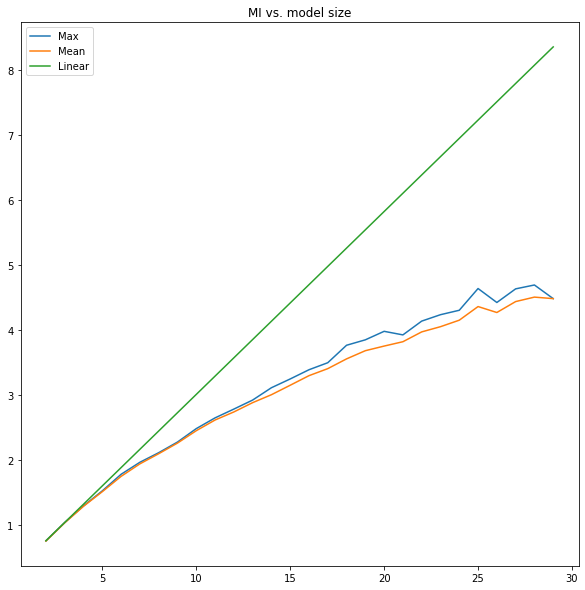

In [2]:
with open('saved_MI_best_dictionary.pkl', 'rb') as file:
    mis_loaded_1 = dill.load(file)
with open('saved_MI_best_dictionary_4_to_100.pkl', 'rb') as file:
    mis_loaded_2 = dill.load(file)
with open('saved_MI_best_dictionary_18_to_100.pkl', 'rb') as file:
    mis_loaded_3 = dill.load(file)

fused_mis = [mis_loaded_1[k] + mis_loaded_2[k] + mis_loaded_3[k]  for k in range(30)]
ks=[]
vs=[]
ms=[]
for k, t in enumerate(fused_mis):
    if len(t) > 0:
#         v = [list_.cpu() for list_ in t]
        
#         print(v)
        v=[np.array([tensor.cpu() for tensor in list_]) for list_ in t]
        v=np.concatenate(v)
        ks.append(k)
        print(k, v, np.max(v), np.mean(v))
        vs.append(np.max(v))
        ms.append(np.mean(v))
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title("MI vs. model size")
plt.plot(ks,vs,label="Max")
plt.plot(ks,ms,label="Mean")

import scipy.stats 
slope,intercept, r_value, p_value, std_err=scipy.stats.linregress(ks[:2], vs[:2])
def f(xs, slope,intercept):
    return [x*slope+intercept for x in xs]
plt.plot(ks,f(ks, slope,intercept),label="Linear")
plt.legend()

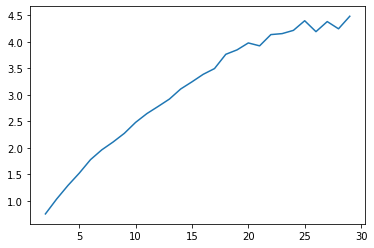

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats
means = [  np.mean(np.array([t.cpu().numpy() for t in mis[k][0]])) for k in mis]
sem = [  scipy.stats.sem(np.array([t.cpu().numpy() for t in mis[k][0]])) for k in mis]

In [ ]:
dat = [np.array([t.cpu().numpy() for t in mis[k][0]] )for k in mis if k != 9]
means = [np.mean(d) for d in dat]
sem = [scipy.stats.sem(d) for d in dat]

In [ ]:
mis

In [ ]:
plt.figure(figsize=(10,10))
dat = [np.array([t.cpu().numpy() for t in mis[k][0]] )for k in mis ]
means = [np.mean(d) for d in dat]
sem = [scipy.stats.sem(d) for d in dat]
plt.errorbar(range(2,15), means, yerr = sem,   marker='x', markersize=15)
plt.xticks(range(2,15))
def f(x_arr, slope, intercept):
    return [slope * x + intercept for x in x_arr]
plt.plot(range(2,15), f(range(2, 15), slope, intercept))
plt.show()

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(2, 5), means[:3])
plt.figure(figsize=(10,10))
plt.errorbar(range(2,12), means, yerr = sem,   marker='x', markersize=15)
plt.xticks(range(2,12))
def f(x_arr, slope, intercept):
    return [slope * x + intercept for x in x_arr]
plt.plot(range(2,12), f(range(2, 12), slope, intercept))
plt.show()

## Scaling of MI as lines
<a id='FC1gLaEA6K8I1foE2nBC56vBPn9n3pC4tuSypqA3BN8'></a>

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from glob import glob
from tqdm import tqdm
from mine.models.layers import ConcatLayer, CustomSequential
from mine.models.mine import EMALoss, ema, ema_loss
import dill
import os
import gc
from collections import defaultdict

    
import ray

# ray.init()
class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)
        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])
            #print("t_marg", t_marg.shape, t_marg)
            #print("second_term", second_term)
        #print(-t, second_term)
        return -t + second_term

    def mi(self, x, z, z_marg=None):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        if isinstance(z, np.ndarray):
            z = torch.from_numpy(z).float()

        with torch.no_grad():
            mi = -self.forward(x, z, z_marg)
        return mi

    def optimize(self, X, Y, iters, batch_size, lr=1e-4, opt=None, 
                 train_loader = None, schedule = None, iter_mi = 30):
        best_mi = -1
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        if schedule is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                        step_size=schedule['step_size'], 
                                                        gamma=schedule['gamma'])


        for iter in range(1, iters + 1):
            
            mu_mi = 0
            # for x, y in mine.utils.batch(X, Y, batch_size):
            for batch, (x, y) in enumerate(train_loader):
                opt.zero_grad()
                loss = self.forward(x.float().cuda(), y.float().cuda())
                loss.backward(retain_graph=True)
                opt.step()

                mu_mi -= loss.item()
            #iter_print = iter //  3
            iter_print = 3
            if iter % (iter_print) == 0:
                # pass
                print(f"It {iter} - MI: {mu_mi / batch_size} ")
            
            if iter % (iter_mi) == 0:
                current_mi = self.mi(torch.Tensor(X).cuda(), torch.Tensor(Y).cuda())
                print(f"It {iter} - Current MI: {current_mi} ")
                if best_mi < current_mi:
                    best_mi = current_mi
        final_mi = self.mi(torch.Tensor(X).cuda(), torch.Tensor(Y).cuda())
        print(f"Final MI: {final_mi}")
        if best_mi < final_mi:
            best_mi = final_mi
        return final_mi, best_mi



class AltNet(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 100):
        super(AltNet, self).__init__()
        self.x_fc1 = nn.Linear(x_dim + y_dim, H)
        self.x_fc2 = nn.Linear(H, H)
        self.x_fc3 = nn.Linear(H, H)
        self.x_fc4 = nn.Linear(H, 1)
        
        
    def forward(self, x, y):
        xy = torch.cat([x, y], 1) # dim [batch, 2]
        inter_xy = F.relu(self.x_fc1(xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc2(inter_xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc3(inter_xy)) # dim [batch, 100]
        
        h2 = (self.x_fc4(inter_xy))
        return h2    

class DatasetVar(Dataset):
    def __init__(self, varX, varY):
        self.varX = varX
        self.varY = varY
        
        assert len(varX) == len(varY), "X and Y must have equal length"
    def __len__(self):
        return len(self.varX)
    def __getitem__(self, idx):
        return self.varX[idx], self.varY[idx]
    
    
    
def get_line_dataset():
    lattice2187 = glob("../data_2187_1571810501/lattice_*")
    dataset = []
    for _ in range(1000):
        dat = np.load(np.random.choice(lattice2187))['arr_0']
        i = np.random.choice(dat.shape[0], size=np.random.randint(1, 20), replace=False)
        dataset.append(dat[i])
        if _ % 100 == 0:
            print(_)
            del dat
            gc.collect()
    dataset = np.vstack(dataset)
    print(dataset.shape)
    return dataset


Device: cuda


In [ ]:
if os.path.exists("isinglinefrom2187x2187.npy") == False:
    for i in range(10):
        dataset = get_line_dataset()
        np.save(f"isinglinefrom2187x2187_batch{i}.npy", dataset)
    dat = np.vstack([np.load(path) for path in glob("isingline*")])
    np.save("isinglinefrom2187x2187.npy", dat)
else:
    dat = np.load("isinglinefrom2187x2187.npy")

In [2]:
def compute_linemi(k, dat = dat, random_loc = True):
    # generate dataset of two 
    if random_loc == False:
        i = 1000
    X, Y = [], []
    for num in range(len(dat)):
        if random_loc == True:
            i = np.random.randint(dat.shape[1] - k) # avoid the boundary
        
        X.append(dat[num,i:(i+k)])
        Y.append(np.concatenate([dat[num, :i], dat[num, (i + k):]]))
#         if num > 1000:
#             break
    X = np.array(X).astype(float) 
    Y = np.array(Y).astype(float) 
    
    # compute MI
    mine = Mine(
        T = AltNet(x_dim =  X.shape[1], y_dim = Y.shape[1]),
        loss = 'mine' #mine_biased, fdiv
    ).cuda()
    
    
    train_loader = DataLoader(DatasetVar(X, Y), batch_size=512)
    final_mi, best_mi = mine.optimize(X, Y, iters = 50, batch_size = 512,  iter_mi = 2,
                       train_loader = train_loader, lr = 0.003, 
                       schedule = {'step_size': (30+k*2)/2, 'gamma': 0.5})
    return best_mi
# best_mi = compute_linemi(10)

In [2]:
best_mi_dict_savepath = "saved_lineMI_dictionary_randomloc_job0.pkl"
if os.path.exists(best_mi_dict_savepath) == False:
    mis = defaultdict(list)
else:
    print(f"{best_mi_dict_savepath} exists!")
    with open(best_mi_dict_savepath, 'rb') as file:
        mis = dill.load(file)

for _ in range(10):
    for k in range(1,50):      
        jobs = []
        for _ in range(1):
             best_mi = compute_linemi(k)
#         best_mi = ray.get(jobs)

        print(k, best_mi)
        mis[k].append(best_mi)
        with open(best_mi_dict_savepath, 'wb') as file:
            dill.dump(mis, file)

saved_lineMI_dictionary_randomloc_job0.pkl exists!


NameError: name 'compute_linemi' is not defined

randomlocjobpaths ['saved_lineMI_dictionary_randomloc_150iters_job11.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job12.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job27.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job2.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job22.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job20.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job3.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job23.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job24.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job21.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job29.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job4.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job9.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job17.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job7.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job28.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job25.pkl', 'saved_lineMI_dictionary_randomloc

randomlocjobpaths ['saved_lineMI_dictionary_randomloc_150iters_job11.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job12.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job27.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job2.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job22.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job20.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job3.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job23.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job24.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job21.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job29.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job4.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job9.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job17.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job7.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job28.pkl', 'saved_lineMI_dictionary_randomloc_150iters_job25.pkl', 'saved_lineMI_dictionary_randomloc

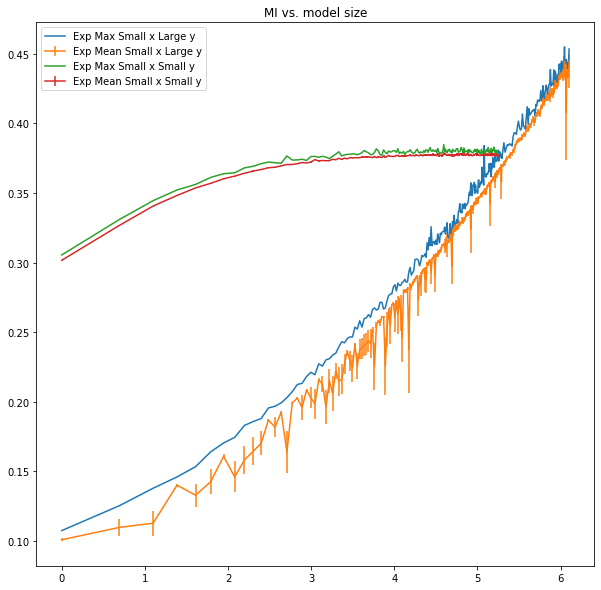

In [13]:
import scipy.stats
randomlocjobpaths = glob('saved_lineMI_dictionary_randomloc_*')
print("randomlocjobpaths", randomlocjobpaths)
fused_mis = defaultdict(list)
for path in randomlocjobpaths:
    with open(path, 'rb') as file:
        mis = dill.load(file)
        for k in mis:
            fused_mis[k].extend(mis[k])
    

    
ks=[]
vs=[]
ms=[]
serrs=[]
for k, t in sorted(fused_mis.items()):
#     print(k)
    if len(t) > 0:
        v = [list_.cpu() for list_ in t]
        v=np.array(v)
        ks.append(k)
#         print(k, v, np.max(v), np.mean(v))
        vs.append(np.max(v))
        ms.append(np.mean(v))
        serrs.append(scipy.stats.sem(v))
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title("MI vs. model size")
plt.errorbar(np.log(ks),(vs),label="Exp Max Small x Large y")
plt.errorbar(np.log(ks),(ms),yerr=serrs,label="Exp Mean Small x Large y")

import scipy.stats 
slope,intercept, r_value, p_value, std_err=scipy.stats.linregress(ks[:2], vs[:2])
def f(xs, slope,intercept):
    return [x*slope+intercept for x in xs]
print("Slope", slope, "intercept", intercept)
# plt.plot(np.log(ks),f(np.log(ks), slope,intercept),label="Linear")

randomlocjobpaths = glob('smallseg_saved_lineMI_dictionary_randomloc_*')
print("randomlocjobpaths", randomlocjobpaths)
fused_mis = defaultdict(list)
for path in randomlocjobpaths:
    with open(path, 'rb') as file:
        mis = dill.load(file)
        for k in mis:
            fused_mis[k].extend(mis[k])
    
import scipy.stats
ks=[]
vs=[]
ms=[]
serrs=[]
for k, t in sorted(fused_mis.items()):
#     print(k)
    if len(t) > 0:
        v = [list_.cpu() for list_ in t]
        v=np.array(v)
        ks.append(k)
#         print(k, v, np.max(v), np.mean(v))
        vs.append(np.max(v))
        ms.append(np.mean(v))
        serrs.append(scipy.stats.sem(v))
plt.errorbar(np.log(ks),(vs),label="Exp Max Small x Small y")
plt.errorbar(np.log(ks),(ms),yerr=serrs,label="Exp Mean Small x Small y")
plt.legend()


randomlocjobpaths ['smallseg_saved_lineMI_dictionary_randomloc_150iters_job3.pkl', 'smallseg_saved_lineMI_dictionary_randomloc_150iters_job6.pkl', 'smallseg_saved_lineMI_dictionary_randomloc_150iters_job5.pkl', 'smallseg_saved_lineMI_dictionary_randomloc_150iters_job2.pkl', 'smallseg_saved_lineMI_dictionary_randomloc_150iters_job8.pkl', 'smallseg_saved_lineMI_dictionary_randomloc_150iters_job7.pkl', 'smallseg_saved_lineMI_dictionary_randomloc_150iters_job4.pkl', 'smallseg_saved_lineMI_dictionary_randomloc_150iters_job1.pkl', 'smallseg_saved_lineMI_dictionary_randomloc_150iters_job0.pkl', 'smallseg_saved_lineMI_dictionary_randomloc_150iters_job9.pkl']


/gpfs/loomis/project/turk-browne/an633/conda_envs/pytorch_resnet/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/gpfs/loomis/project/turk-browne/an633/conda_envs/pytorch_resnet/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


<ErrorbarContainer object of 3 artists>

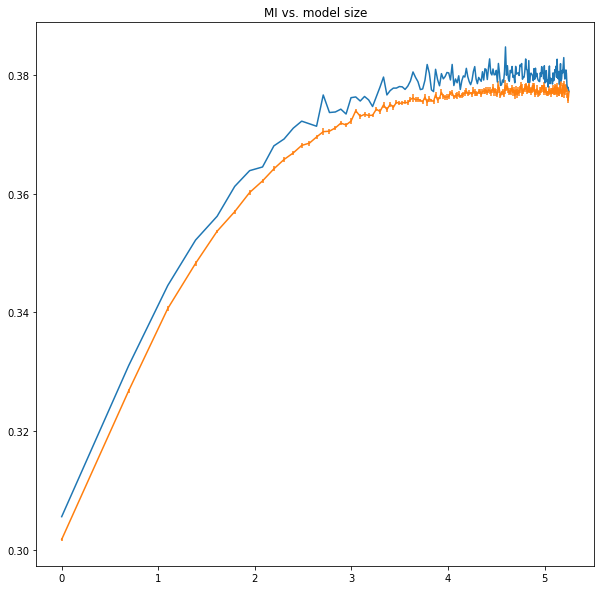

/gpfs/loomis/project/turk-browne/an633/conda_envs/pytorch_resnet/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/gpfs/loomis/project/turk-browne/an633/conda_envs/pytorch_resnet/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


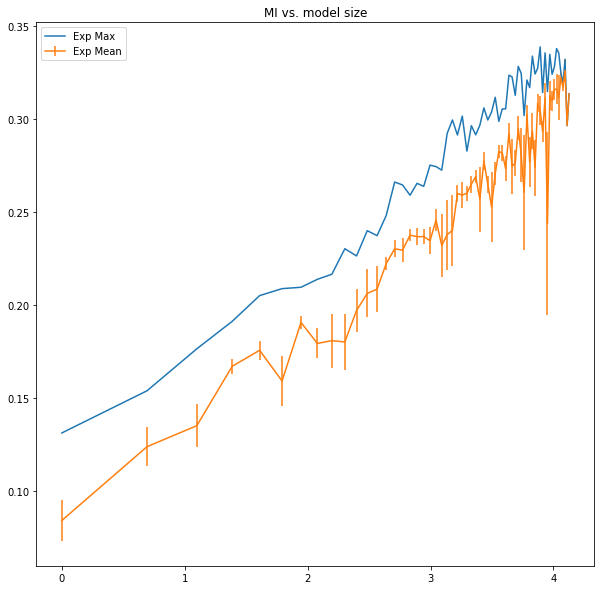

In [3]:
randomlocjobpaths = glob('saved_lineMI_dictionary_randomloc_150iters*')
fused_mis = defaultdict(list)
for path in randomlocjobpaths:
    with open(path, 'rb') as file:
        mis = dill.load(file)
        for k in mis:
            fused_mis[k].extend(mis[k])
    
import scipy.stats
ks=[]
vs=[]
ms=[]
serrs=[]
for k, t in fused_mis.items():
    if len(t) > 0:
        v = [list_.cpu() for list_ in t]
        v=np.array(v)
        ks.append(k)
#         print(k, v, np.max(v), np.mean(v))
        vs.append(np.max(v))
        ms.append(np.mean(v))
        serrs.append(scipy.stats.sem(v))
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title("MI vs. model size")
plt.errorbar(np.log(ks),(vs),label="Exp Max")
plt.errorbar(np.log(ks),(ms),yerr=serrs,label="Exp Mean")

import scipy.stats 
slope,intercept, r_value, p_value, std_err=scipy.stats.linregress(ks[:2], vs[:2])
def f(xs, slope,intercept):
    return [x*slope+intercept for x in xs]
# plt.plot(ks,f(ks, slope,intercept),label="Linear")
plt.legend()

# Compare MINE vs. Joint-vs-Marginal Estimators
<a id='uUErzTXITRwiuLX3vbfqwnke2vR86I8SGE7kaab8V14'></a>

In [2]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from glob import glob
from tqdm import tqdm
from mine.models.layers import ConcatLayer, CustomSequential
from mine.models.mine import EMALoss, ema, ema_loss
import dill
import os
import gc
from collections import defaultdict
import scipy.stats
import matplotlib.pyplot as plt
    
import ray

# ray.init()
class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)
        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])
            #print("t_marg", t_marg.shape, t_marg)
            #print("second_term", second_term)
        #print(-t, second_term)
        return -t + second_term

    def mi(self, x, z, z_marg=None):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        if isinstance(z, np.ndarray):
            z = torch.from_numpy(z).float()

        with torch.no_grad():
            mi = -self.forward(x, z, z_marg)
        return mi

    def optimize(self, X, Y, iters, batch_size, lr=1e-4, opt=None, 
                 train_loader = None, schedule = None, iter_mi = 30):
        best_mi = -1
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        if schedule is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                        step_size=schedule['step_size'], 
                                                        gamma=schedule['gamma'])


        for iter in range(1, iters + 1):
            
            mu_mi = 0
            # for x, y in mine.utils.batch(X, Y, batch_size):
            for batch, (x, y) in enumerate(train_loader):
                opt.zero_grad()
                loss = self.forward(x.float().cuda(), y.float().cuda())
                loss.backward(retain_graph=True)
                opt.step()

                mu_mi -= loss.item()
            #iter_print = iter //  3
            iter_print = 3
            if iter % (iter_print) == 0:
                # pass
                print(f"It {iter} - MI: {mu_mi / batch_size} ")
            
            if iter % (iter_mi) == 0:
                current_mi = self.mi(torch.Tensor(X).cuda(), torch.Tensor(Y).cuda())
                print(f"It {iter} - Current MI: {current_mi} ")
                if best_mi < current_mi:
                    best_mi = current_mi
        final_mi = self.mi(torch.Tensor(X).cuda(), torch.Tensor(Y).cuda())
        print(f"Final MI: {final_mi}")
        if best_mi < final_mi:
            best_mi = final_mi
        return final_mi, best_mi



class AltNet(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 30):
        super(AltNet, self).__init__()
        self.x_fc1 = nn.Linear(x_dim + y_dim, H)
        self.x_fc2 = nn.Linear(H, H)
        self.x_fc3 = nn.Linear(H, H)
        self.x_fc4 = nn.Linear(H, 1)
        
        
    def forward(self, x, y):
        xy = torch.cat([x, y], 1) # dim [batch, 2]
        inter_xy = F.relu(self.x_fc1(xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc2(inter_xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc3(inter_xy)) # dim [batch, 100]
        
        h2 = (self.x_fc4(inter_xy))
        return h2    

class DatasetVar(Dataset):
    def __init__(self, varX, varY):
        self.varX = varX
        self.varY = varY
        
        assert len(varX) == len(varY), "X and Y must have equal length"
    def __len__(self):
        return len(self.varX)
    def __getitem__(self, idx):
        return self.varX[idx], self.varY[idx]
    
    


Device: cuda


## MINE on 2 1D Gaussians
<a id='urFfwvFLj2Tz0PwJR8g'></a>

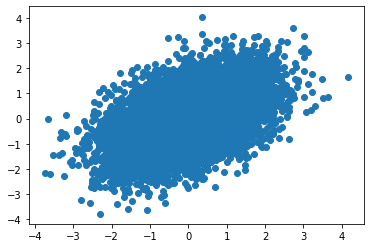

It 2 - Current MI: 0.13457311689853668 
It 3 - MI: 0.004941498627886176 
It 4 - Current MI: 0.1370779275894165 
It 6 - MI: 0.005618152674287558 
It 6 - Current MI: 0.13581880927085876 
It 8 - Current MI: 0.14410313963890076 
It 9 - MI: 0.005186857422813773 
It 10 - Current MI: 0.14214517176151276 
It 12 - MI: 0.005242457133135758 
It 12 - Current MI: 0.1359904259443283 
It 14 - Current MI: 0.13561320304870605 
It 15 - MI: 0.00547867501154542 
It 16 - Current MI: 0.13962480425834656 
It 18 - MI: 0.005776116449851543 
It 18 - Current MI: 0.15603560209274292 
It 20 - Current MI: 0.13437622785568237 
It 21 - MI: 0.005422639544121921 
It 22 - Current MI: 0.14937064051628113 
It 24 - MI: 0.005227450717939064 
It 24 - Current MI: 0.14208830893039703 
It 26 - Current MI: 0.13475312292575836 
It 27 - MI: 0.005419497450930066 
It 28 - Current MI: 0.1472015678882599 
It 30 - MI: 0.005502649728441611 
It 30 - Current MI: 0.13908402621746063 
It 32 - Current MI: 0.12885740399360657 
It 33 - MI: 0.0

tensor(0.1560, device='cuda:0')

In [48]:
def get_Gaussian_data_set(corr):
    dim = 2
    X, Y = scipy.stats.multivariate_normal.rvs(mean = [0, 0], cov= [[1, corr], [corr, 1]], size=10000).T
    return X, Y
    
def compute_mi(get_data_set, corr):
    
    X, Y = get_data_set(corr)
    plt.scatter(X, Y)
    plt.show()
    X = np.array(X).reshape(-1, 1).astype(float) 
    Y = np.array(Y).reshape(-1, 1).astype(float) 
    # compute MI
    mine = Mine(
        T = AltNet(x_dim =  X.shape[1], y_dim = Y.shape[1]),
        loss = 'mine' #mine_biased, fdiv
    ).cuda()
    
    
    train_loader = DataLoader(DatasetVar(X, Y), batch_size=512)
    final_mi, best_mi = mine.optimize(X, Y, iters = 60, batch_size = 512,  iter_mi = 2,
                       train_loader = train_loader, lr = 0.003, 
                       schedule = {'step_size': 15, 'gamma': 0.5})
    return best_mi


   
best_mi_dict_savepath = "mine_vs_marginal-vs-joint_MINE.pkl"
if os.path.exists(best_mi_dict_savepath) == False:
    mis = defaultdict(list)
else:
    print(f"{best_mi_dict_savepath} exists!")
    with open(best_mi_dict_savepath, 'rb') as file:
        mis = dill.load(file)

for corr in np.linspace(-1, 1, 50):
    best_mi = compute_mi(get_Gaussian_data_set, corr)
    mis[corr].append(best_mi)
    with open(best_mi_dict_savepath, 'wb') as file:
        dill.dump(mis, file)
    


## p/(1-p) on 2 1D Gaussians
<a id='uhpeGwwardgoo/fW6QB9f7'></a>

In [104]:


class Joint_net(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, xy_dim, H = 100):
        super(Joint_net, self).__init__()
        self.x_fc1 = nn.Linear(xy_dim, H)
        self.x_fc2 = nn.Linear(H, H)
        self.x_fc3 = nn.Linear(H, H)
        self.x_fc4 = nn.Linear(H, 1)
        
    def forward(self, xy):
#         xy = torch.cat([x, y], 1) # dim [batch, 2]
        inter_xy = F.relu(self.x_fc1(xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc2(inter_xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc3(inter_xy)) # dim [batch, 100]
        
        h2 = F.sigmoid(self.x_fc4(inter_xy))
        return h2  

In [ ]:
def get_Gaussian_data_set(corr):
    dim = 2
    X, Y = scipy.stats.multivariate_normal.rvs(mean = [0, 0], cov= [[1, corr], [corr, 1]], size=10000).T
    return X, Y
    
def compute_mi(get_data_set, corr, opt=None,
              schedule = {'step_size': 15, 'gamma': 0.5},
               lr=0.003, iters = 150, iter_mi=3
              ):
    
    X, Y = get_data_set(corr)
    plt.scatter(X, Y)
    plt.show()
    X = np.array(X).reshape(-1, 1).astype(float) 
    Y = np.array(Y).reshape(-1, 1).astype(float) 
    XY_joint = (np.concatenate([X,(Y)],1))
    XY_marg = (np.concatenate([X,np.random.permutation(Y)],1))
#     plt.scatter(XY_joint[:,0], XY_joint[:,1])
#     plt.show()
    XY = np.vstack([XY_joint, XY_marg])
    XY = torch.Tensor(XY).cuda()
    labels = np.concatenate([np.ones(XY_joint.shape[0]), np.zeros(XY_marg.shape[0])]).reshape(-1, 1)
    labels = torch.Tensor(labels).cuda()
    XY_joint = torch.Tensor(XY_joint).cuda()
    print(labels.shape)
    
       
    # compute MI
    model = Joint_net(xy_dim =  XY.shape[1]).cuda()
    if opt is None:
            opt = torch.optim.Adam(model.parameters(), lr=lr)
    if schedule is not None:
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                    step_size=schedule['step_size'], 
                                                    gamma=schedule['gamma'])
    train_loader = DataLoader(DatasetVar(XY, labels), batch_size=512, shuffle=True)
    loss = torch.nn.BCELoss()
    best_mi = -1
    for iter_ in range(1, iters + 1):
        for batch, (xy, label) in enumerate(train_loader):
            opt.zero_grad()
            output = loss(model(xy), label)
            
            
                    
                    
            output.backward()
            opt.step()
            
        

        if iter_ % (iter_mi) == 1:
            p = model(XY_joint)

            current_mi = torch.mean(torch.log(p / (1-p)))
            print(f"It {iter_} - Current MI: {current_mi} ")
            if best_mi < current_mi:
                best_mi = current_mi
                
        # Get accuracy after every epoch
#         acc = 0
#         print("len(train_loader)", len(train_loader))
#         for batch, (xy, label) in enumerate(train_loader):
#             predictions = model(xy)
#             for p, y in zip(predictions, label):
#                 if y == 1:
#                     acc += p
#                 if y == 0:
#                     acc += (1-p)
#         acc /= 20000
#         print(f"Iteration {iter_}, Accuracy: {acc}")
                
    return best_mi
            

best_mi_dict_savepath = "mine_vs_marginal-vs-joint_MARGINALvsJOINT.pkl"
if os.path.exists(best_mi_dict_savepath) == False:
    mis = defaultdict(list)
else:
    print(f"{best_mi_dict_savepath} exists!")
    with open(best_mi_dict_savepath, 'rb') as file:
        mis = dill.load(file)

for corr in np.linspace(-1, 1, 50):
    best_mi = compute_mi(get_Gaussian_data_set, corr)
    mis[corr].append(best_mi)
    with open(best_mi_dict_savepath, 'wb') as file:
        dill.dump(mis, file)



## MINE on 2 10D Gaussians
<a id='U5pun0GG3L7I5Kawd5kg5S0vDRqOiUu92bwFgd1rjyw'></a>

In [87]:

    
def get_Gaussian_data_set(corr):
    XY = scipy.stats.multivariate_normal.rvs(mean = np.hstack([np.zeros(10), np.zeros(10)]), 
                                               cov= np.eye(20) + corr*np.diag(np.ones(10), -10) + corr*np.diag(np.ones(10), 10),
                                               size=10000).T
    return XY
    
def compute_mi(get_data_set, corr):
    
    XY = get_data_set(corr)
#     plt.scatter(X, Y)
#     plt.show()
    X = np.array(XY[:10,:]).reshape(-1, 10).astype(float) 
    Y = np.array(XY[10:,:]).reshape(-1, 10).astype(float) 
    # compute MI
    mine = Mine(
        T = AltNet(x_dim =  X.shape[1], y_dim = Y.shape[1]),
        loss = 'mine' #mine_biased, fdiv
    ).cuda()
    
    
    train_loader = DataLoader(DatasetVar(X, Y), batch_size=512)
    final_mi, best_mi = mine.optimize(X, Y, iters = 80, batch_size = 512,  iter_mi = 2,
                       train_loader = train_loader, lr = 0.003, 
                       schedule = {'step_size': 15, 'gamma': 0.5})
    return best_mi
   
best_mi_dict_savepath = "mine_vs_marginal-vs-joint_MINE_20dim.pkl"
if os.path.exists(best_mi_dict_savepath) == False:
    mis = defaultdict(list)
else:
    print(f"{best_mi_dict_savepath} exists!")
    with open(best_mi_dict_savepath, 'rb') as file:
        mis = dill.load(file)

for corr in np.linspace(-1, 1, 50):
    best_mi = compute_mi(get_Gaussian_data_set, corr)
    mis[corr].append(best_mi)
    with open(best_mi_dict_savepath, 'wb') as file:
        dill.dump(mis, file)
    


mine_vs_marginal-vs-joint_MINE_20dim.pkl exists!
It 2 - Current MI: 3.7777962684631348 
It 3 - MI: 0.16722000017762184 
It 4 - Current MI: 5.6638264656066895 
It 6 - MI: 0.20726669393479824 
It 6 - Current MI: 5.6334099769592285 
It 8 - Current MI: 4.492313385009766 
It 9 - MI: 0.17180902510881424 
It 10 - Current MI: 5.168447017669678 
It 12 - MI: 0.1879331530071795 
It 12 - Current MI: 5.580033302307129 
It 14 - Current MI: 6.39089822769165 
It 15 - MI: 0.21902117226272821 
It 16 - Current MI: 5.514887809753418 
It 18 - MI: 0.23179037775844336 
It 18 - Current MI: 6.402785778045654 
It 20 - Current MI: 6.5563859939575195 
It 21 - MI: 0.2523554819636047 
It 22 - Current MI: 6.230814456939697 
It 24 - MI: 0.23566960683092475 
It 24 - Current MI: 6.48348331451416 
It 26 - Current MI: 5.8986053466796875 
It 27 - MI: 0.2327542221173644 
It 28 - Current MI: 8.467926025390625 
It 30 - MI: 0.26318354345858097 
It 30 - Current MI: 7.213029384613037 
It 32 - Current MI: 7.656398296356201 
It 3

KeyboardInterrupt: 

In [114]:
import pandas as pd
mat = np.eye(20) + np.diag(np.ones(10), -10) + np.diag(np.ones(10), 10)
pd.DataFrame(mat)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## p/(1-p) on 2 10D Gaussians
<a id='lOMJw8rnW3QXotwiPSoTrhN2AoP2O0pMG1QA5M'></a>

In [88]:


class Joint_net(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, xy_dim, H = 100):
        super(Joint_net, self).__init__()
        self.x_fc1 = nn.Linear(xy_dim, H)
        self.x_fc2 = nn.Linear(H, H)
        self.x_fc3 = nn.Linear(H, H)
        self.x_fc4 = nn.Linear(H, 1)
        
    def forward(self, xy):
#         xy = torch.cat([x, y], 1) # dim [batch, 2]
        inter_xy = F.relu(self.x_fc1(xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc2(inter_xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc3(inter_xy)) # dim [batch, 100]
        
        h2 = F.sigmoid(self.x_fc4(inter_xy))
        return h2  
    
def get_Gaussian_data_set(corr):
    dim = 2
    XY = scipy.stats.multivariate_normal.rvs(mean = np.hstack([np.zeros(10), np.zeros(10)]), 
                                               cov= np.eye(20) + corr * np.diag(np.ones(10), -10) + corr * np.diag(np.ones(10), 10),
                                               size=10000).T
    return XY

def compute_mi(get_data_set, corr, opt=None,
              schedule = {'step_size': 75, 'gamma': 0.5},
               lr=0.003, iters = 150, iter_mi=3
              ):
    
    XY = get_data_set(corr)
#     plt.scatter(X, Y)
#     plt.show()
    X = np.array(XY[:10,:]).reshape(-1, 10).astype(float) 
    Y = np.array(XY[10:,:]).reshape(-1, 10).astype(float) 
    XY_joint = (np.concatenate([X,(Y)],1))
    XY_marg = (np.concatenate([X,np.random.permutation(Y)],1))
#     plt.scatter(XY_joint[:,0], XY_joint[:,1])
#     plt.show()
    XY = np.vstack([XY_joint, XY_marg])
    XY = torch.Tensor(XY).cuda()

    labels = np.concatenate([np.ones(XY_joint.shape[0]), np.zeros(XY_marg.shape[0])]).reshape(-1, 1)
    labels = torch.Tensor(labels).cuda()
    XY_joint = torch.Tensor(XY_joint).cuda()
    print(labels.shape)
    
       
    # compute MI
    model = Joint_net(xy_dim =  XY.shape[1]).cuda()
    if opt is None:
            opt = torch.optim.Adam(model.parameters(), lr=lr)
    if schedule is not None:
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                    step_size=schedule['step_size'], 
                                                    gamma=schedule['gamma'])
    train_loader = DataLoader(DatasetVar(XY, labels), batch_size=512, shuffle=True)
    loss = torch.nn.BCELoss()
    best_mi = -1
    for iter_ in range(1, iters + 1):
        for batch, (xy, label) in enumerate(train_loader):
            opt.zero_grad()
            output = loss(model(xy), label)
            output.backward()
            opt.step()
            
        if iter_ % (iter_mi) == 1:
            p = model(XY_joint)

            current_mi = -torch.mean(torch.log(p*(1-p)))
            print(f"It {iter_} - Current MI: {current_mi} ")
            if best_mi < current_mi:
                best_mi = current_mi
                
    return best_mi
            

best_mi_dict_savepath = "mine_vs_marginal-vs-joint_MARGINALvsJOINT_20dim.pkl"
if os.path.exists(best_mi_dict_savepath) == False:
    mis = defaultdict(list)
else:
    print(f"{best_mi_dict_savepath} exists!")
    with open(best_mi_dict_savepath, 'rb') as file:
        mis = dill.load(file)

for corr in np.linspace(-1, 1, 50):
    best_mi = compute_mi(get_Gaussian_data_set, corr)
    mis[corr].append(best_mi)
    with open(best_mi_dict_savepath, 'wb') as file:
        dill.dump(mis, file)
    

torch.Size([20000, 1])


/gpfs/loomis/project/turk-browne/an633/conda_envs/pytorch_resnet/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


It 1 - Current MI: inf 
It 4 - Current MI: inf 
It 7 - Current MI: inf 
It 10 - Current MI: inf 
It 13 - Current MI: inf 
It 16 - Current MI: inf 
It 19 - Current MI: inf 
It 22 - Current MI: inf 
It 25 - Current MI: inf 
It 28 - Current MI: inf 
It 31 - Current MI: inf 
It 34 - Current MI: inf 
It 37 - Current MI: inf 
It 40 - Current MI: inf 
It 43 - Current MI: inf 
It 46 - Current MI: inf 
It 49 - Current MI: inf 
It 52 - Current MI: inf 
It 55 - Current MI: inf 
It 58 - Current MI: inf 
It 61 - Current MI: inf 
It 64 - Current MI: inf 
It 67 - Current MI: inf 
It 70 - Current MI: inf 
It 73 - Current MI: inf 
It 76 - Current MI: inf 
It 79 - Current MI: inf 
It 82 - Current MI: inf 
It 85 - Current MI: inf 
It 88 - Current MI: inf 
It 91 - Current MI: inf 
It 94 - Current MI: inf 
It 97 - Current MI: inf 
It 100 - Current MI: inf 
It 103 - Current MI: inf 
It 106 - Current MI: inf 
It 109 - Current MI: inf 
It 112 - Current MI: inf 
It 115 - Current MI: inf 
It 118 - Current MI: i

KeyboardInterrupt: 

## Plot results

In [21]:
with open("mine_vs_marginal-vs-joint_MINE.pkl", 'rb') as file:
    mine_mi = dill.load(file)
with open("mine_vs_marginal-vs-joint_MARGINALvsJOINT.pkl", 'rb') as file:
    jvm_mi = dill.load(file)

In [22]:
np.hstack([max_jvm_mis])

array([       inf, 1.5442158 , 1.1498476 , 0.88537407, 0.70945466,
       0.6124331 , 0.5411117 , 0.47254023, 0.48591542, 0.3587759 ],
      dtype=float32)

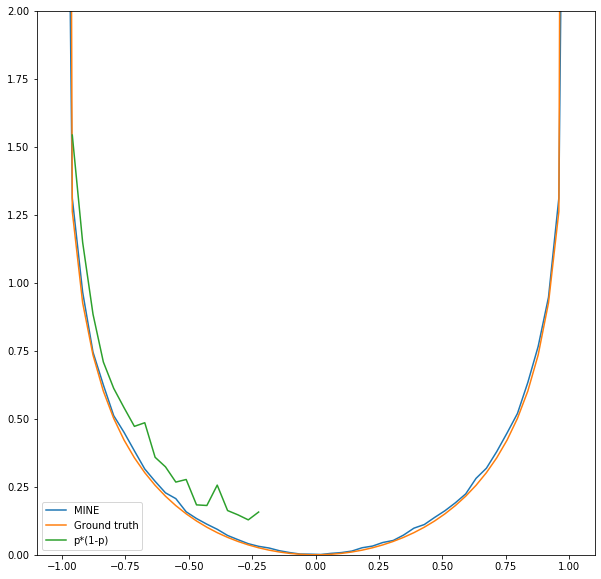

In [23]:
plt.figure(figsize=(10,10))
max_mine_mis = [np.max([t.cpu().detach().numpy() for t in mine_mi[k]]) for k in mine_mi ]
k_mine_mis = [k for k in mine_mi]
plt.plot(k_mine_mis, max_mine_mis,label="MINE")
plt.plot(k_mine_mis, [np.log((1/(1-r**2+1e-10))**(0.5)) for r in k_mine_mis], label="Ground truth")

max_jvm_mis = [[t.cpu().detach().numpy() for t in jvm_mi[k] if t is not None]  for k in jvm_mi ]
max_jvm_mis = [np.max(t) for t in max_jvm_mis if len(t) > 0]
k_jvm_mis = [k for k in jvm_mi]
plt.plot(k_jvm_mis, np.hstack([max_jvm_mis]), label="p*(1-p)")
plt.ylim(0, 2)
plt.legend()
plt.show()

In [24]:

with open("mine_vs_marginal-vs-joint_MINE_20dim.pkl", 'rb') as file:
    mine_mi = dill.load(file)
# with open("mine_vs_marginal-vs-joint_MARGINALvsJOINT_20dim.pkl", 'rb') as file:
#     jvm_mi = dill.load(file)

In [25]:
mine_mi

defaultdict(list,
            {-1.0: [tensor(9.7358, device='cuda:0')],
             -0.9591836734693877: [tensor(8.2470, device='cuda:0')],
             -0.9183673469387755: [tensor(7.1068, device='cuda:0')],
             -0.8775510204081632: [tensor(5.7130, device='cuda:0')],
             -0.8367346938775511: [tensor(4.9825, device='cuda:0')],
             -0.7959183673469388: [tensor(4.4988, device='cuda:0')],
             -0.7551020408163265: [tensor(3.8151, device='cuda:0')],
             -0.7142857142857143: [tensor(3.1901, device='cuda:0')],
             -0.6734693877551021: [tensor(2.8549, device='cuda:0')],
             -0.6326530612244898: [tensor(2.3469, device='cuda:0')],
             -0.5918367346938775: [tensor(2.0659, device='cuda:0')],
             -0.5510204081632654: [tensor(1.7494, device='cuda:0')],
             -0.5102040816326531: [tensor(1.4524, device='cuda:0')],
             -0.4693877551020409: [tensor(1.2217, device='cuda:0')],
             -0.428571428571428

In [103]:
jvm_mi

defaultdict(list,
            {-1.0: [tensor(inf, device='cuda:0', requires_grad=True),
              tensor(inf, device='cuda:0', requires_grad=True)],
             -0.9591836734693877: [tensor(inf, device='cuda:0', requires_grad=True)],
             -0.9183673469387755: [tensor(inf, device='cuda:0', requires_grad=True)],
             -0.8775510204081632: [tensor(inf, device='cuda:0', requires_grad=True)],
             -0.8367346938775511: [tensor(inf, device='cuda:0', requires_grad=True)]})

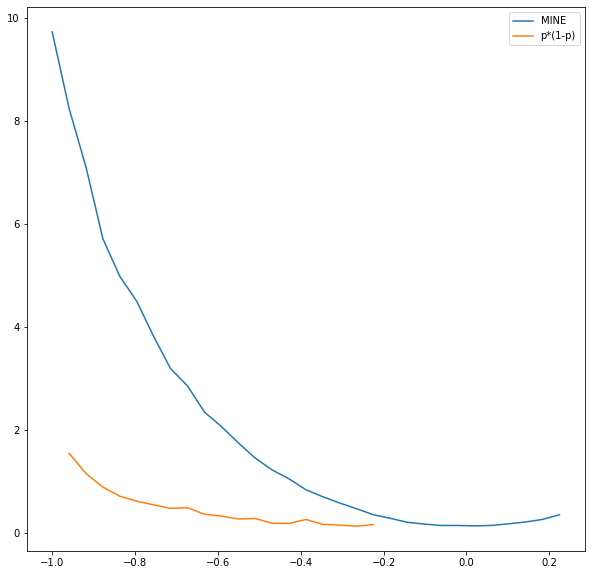

In [26]:
plt.figure(figsize=(10,10))
max_mine_mis = [np.max([t.cpu().detach().numpy() for t in mine_mi[k]]) for k in mine_mi ]
k_mine_mis = [k for k in mine_mi]
plt.plot(k_mine_mis, max_mine_mis,label="MINE")
# plt.plot(k_mine_mis, [np.log((1/(1-r**2+1e-10))**(0.5)) for r in k_mine_mis], label="Ground truth")

max_jvm_mis = [[t.cpu().detach().numpy() for t in jvm_mi[k] if t is not None]  for k in jvm_mi ]
max_jvm_mis = [np.max(t) for t in max_jvm_mis if len(t) > 0]
k_jvm_mis = [k for k in jvm_mi]
plt.plot(k_jvm_mis, np.hstack([max_jvm_mis]), label="p*(1-p)")
plt.legend()
plt.show()


# Analytic MI frozen convolution
<a id='IMXNuzYpbqF3yE71tcGPkyCUgonu44gg0wtJKI'></a>

In [ ]:
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])

In [ ]:
import matplotlib.pyplot as plt
plt.hist()

In [ ]:
X

In [ ]:
Y

In [ ]:
xy_pair = np.vstack([X, Y]).T
xy_pair

In [ ]:
from collections import defaultdict
joint_dict = defaultdict(int)
marginal_x = defaultdict(int)
marginal_y = defaultdict(int)
for pair in xy_pair:
    joint_dict[(tuple(pair))] += 1
    marginal_x[tuple(pair)[0]] += 1
    marginal_y[tuple(pair)[1]] += 1

In [ ]:
joint_dict

In [ ]:
marginal_x

In [ ]:
marginal_y

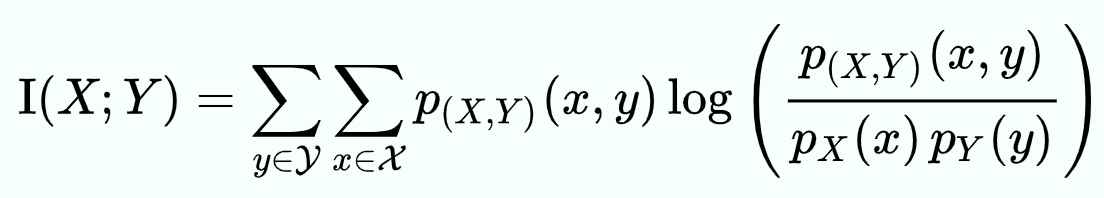

In [ ]:

def normalize_dict(dictionary):
    sum_ = 0
    for xy in dictionary:
        sum_ += dictionary[xy]
    for xy in dictionary:
        dictionary[xy] = dictionary[xy] / (sum_)
    return dictionary
joint_dict = normalize_dict(joint_dict)
marginal_x = normalize_dict(marginal_x)
marginal_y = normalize_dict(marginal_y)


In [ ]:
MI = 0
for xy in joint_dict:
    p_xy = joint_dict[xy]
    p_x = marginal_x[xy[0]]
    p_y = marginal_y[xy[1]]
    MI += p_xy * np.log (p_xy / (p_x * p_y))

In [ ]:
MI

## Analytic fine-grained MI calculation
<a id='W6fWYl5TZGWfK9Zt8dXCH65nSc5Uk'></a>

In [ ]:
X = np.array(Xlist).astype(float)#.reshape(-1, 9)
Y = np.array(Ylist).astype(float)#.reshape(-1, 9)

In [ ]:
X

In [ ]:
Xlist2x2 = []
Ylist2x2 = []
for _ in range(100000):
    num = np.random.randint(dat.shape[0])
    i = np.random.randint(dat.shape[1] - 3)
    j = np.random.randint(dat.shape[1] - 6)

    Xlist2x2.append(dat[num, i:(i+2), j:(j+2)])
    Ylist2x2.append(dat[num, i:(i+2), (j+2):(j+4)])

X = np.array(Xlist2x2).astype(float).reshape(-1, 4)
Y = np.array(Ylist2x2).astype(float).reshape(-1, 4)

In [ ]:
X

In [ ]:
Y

In [ ]:
xy_pair = np.hstack([X, Y])

In [ ]:
xy_pair[:3, :]

In [ ]:
joint_dict = defaultdict(int)
marginal_x = defaultdict(int)
marginal_y = defaultdict(int)
for pair in xy_pair:
    joint_dict[(tuple(pair))] += 1
    marginal_x[tuple(pair)[:4]] += 1
    marginal_y[tuple(pair)[4:]] += 1

In [ ]:
joint_dict

In [ ]:

def normalize_dict(dictionary):
    sum_ = 0
    for xy in dictionary:
        sum_ += dictionary[xy]
    for xy in dictionary:
        dictionary[xy] = dictionary[xy] / (sum_)
    return dictionary
joint_dict = normalize_dict(joint_dict)
marginal_x = normalize_dict(marginal_x)
marginal_y = normalize_dict(marginal_y)


In [ ]:
MI = 0
for xy in joint_dict:
    p_xy = joint_dict[xy]
    p_x = marginal_x[xy[:4]]
    p_y = marginal_y[xy[4:]]
    MI += p_xy * np.log (p_xy / (p_x * p_y))

In [ ]:
MI

In [ ]:
Ylist2x2

## Analytic MI frozen convolution
<a id='i4EUlSNUCLAqQFRTDCFVrpJ'></a>

In [ ]:
X = 1/4 * (np.array(Xlist2x2).astype(float).sum(axis = (1, 2))  )
Y = 1/4 * (np.array(Ylist2x2).astype(float).sum(axis = (1, 2))  )

In [ ]:
X

In [ ]:
Y

In [ ]:
xy_pair = np.vstack([X, Y]).T
xy_pair

In [ ]:
from collections import defaultdict
joint_dict = defaultdict(int)
marginal_x = defaultdict(int)
marginal_y = defaultdict(int)
for pair in xy_pair:
    joint_dict[(tuple(pair))] += 1
    marginal_x[tuple(pair)[0]] += 1
    marginal_y[tuple(pair)[1]] += 1

In [ ]:
joint_dict

In [ ]:
marginal_x

In [ ]:
marginal_y

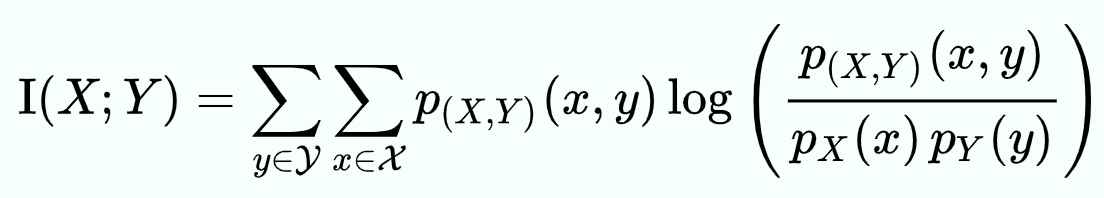

In [ ]:

def normalize_dict(dictionary):
    sum_ = 0
    for xy in dictionary:
        sum_ += dictionary[xy]
    for xy in dictionary:
        dictionary[xy] = dictionary[xy] / (sum_)
    return dictionary
joint_dict = normalize_dict(joint_dict)
marginal_x = normalize_dict(marginal_x)
marginal_y = normalize_dict(marginal_y)


In [ ]:
MI = 0
for xy in joint_dict:
    p_xy = joint_dict[xy]
    p_x = marginal_x[xy[0]]
    p_y = marginal_y[xy[1]]
    MI += p_xy * np.log (p_xy / (p_x * p_y))

In [ ]:
MI

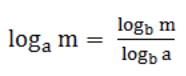

In [ ]:
log_2 x = log_e x / log_e 2
log_e (x() = log_2 (x) * log_e (2)


In [ ]:
Fine_grained MI = 0.62  / np.log(2)

In [ ]:
Fine_grained MI = 0.71

- Mine on the fine-grained data (on the 2x2 model)
- Mine on the frozen convolution coarse-graining (on the 2x2 model)
- Mine on the unfrozen convolution (and we optimize the convolution to get max info) (on the 2x2 model)
- Figure out if the log2 factor is confusing